<a href="https://colab.research.google.com/github/les67/Generative_Adversarial_Networks/blob/main/jlab_2_criticalcare_gan_wgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interview Problems for Data Science Postdoc position

## Problem #2 (generative models)

The goal of this exercise is to create a generative adversarial network to reproduce the tabular data found
https://github.com/JeffersonLab/jlab_datascience_data/blob/main/eICU_age.npy. The dataset
includes the ages of critical care patients seen across intensive care units in the United States. The original
data is from the eICU Collaborative Research Database https://eicu-crd.mit.edu/about/eicu/.
To solve this problem implement a generative adversarial network (GAN) in python to produce the distribution of age for these patients. Your script must coordinate both the generator and discriminator models.
Please provide figures to illustrate this coordination and compare the distribution from the generator model
output with that of the true distribution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
from scipy.stats import iqr
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import os
import time

- Load data:

In [ ]:
# Load eICU critical pacient age data
age_data = np.load('/content/drive/MyDrive/eICU_age.npy')
print('Data is of shape {} and of type {}'.format(age_data.shape,age_data.dtype))

age_data = age_data.astype(int) # Change dtype to integers
print('Data is of shape {} and of type {}'.format(age_data.shape,age_data.dtype))

Data is of shape (2520,) and of type [('age', 'i1')]
Data is of shape (2520,) and of type int64


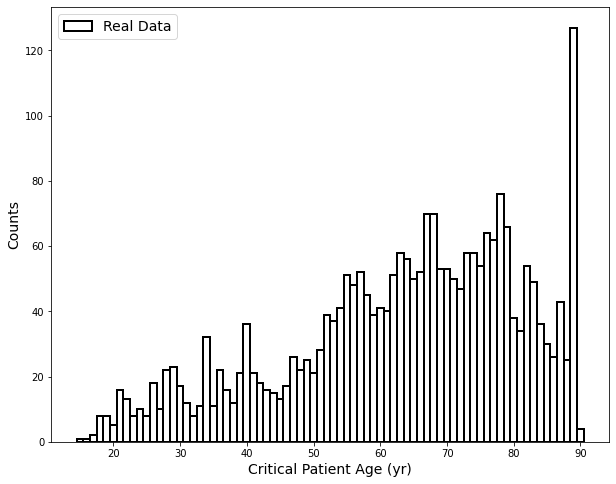

In [ ]:
# Visulize real data
bins = np.arange(np.min(age_data)-0.5,np.max(age_data)+1.5,1)
plt.figure(figsize=(10,8))
age_data_counts, _ , _ = plt.hist(age_data,bins,facecolor='none', linewidth=2,edgecolor='k',alpha=1,label='Real Data')
plt.xlabel('Critical Patient Age (yr)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.legend(fontsize=14)
plt.show()

ages = np.arange(np.min(age_data),np.max(age_data)+1,1)

- Prepare dataset by batches
- For a batch of 200 there are 12.6 batch samples per epoch

In [ ]:
BUFFER_SIZE = age_data.size # 2520 samples
BATCH_SIZE = 200 # gives 12.6 batches per epoch

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(age_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # randomize order and cut into batches

## GAN Implementation:
- Follows classic [GAN paper](https://arxiv.org/abs/1406.2661) idea
- Define Generator and Discriminator models
- Following the NN architectures of https://chunliangli.github.io/docs/dltp17gan.pdf, used to model a GAN for low dimensional distributions (since ours is 1D)

In [ ]:
latent_dim = 100 # dimension of noise space domain
                 # searches for explanation concludes in: this is some magic number most applications use

def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(128,activation='relu',input_shape=(latent_dim,),
                         kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(128,activation='relu',
                         kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(128,activation='relu',
                         kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(1))
  return model

def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(32,activation='relu',input_shape=(1,),
            kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(32,activation='relu',
            kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(32,activation='relu',
            kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(1,activation='sigmoid')) # sigmoid output for binary classification
  return model  

- For the latent "noise" distribution we use the typical normal distrib
- Generate a fake sample population before training

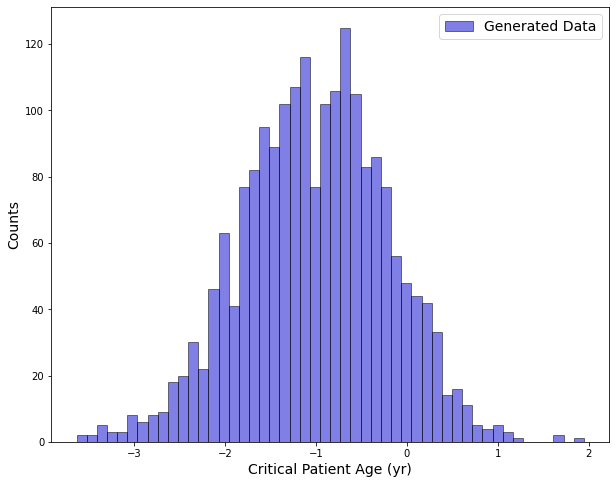

In [ ]:
generator = generator_model()
discriminator = discriminator_model()

generated_samples0 = []
for i in range(2000):
  ii_noise = tf.random.normal([1,latent_dim])
  ii_generated_sample = generator(ii_noise,training=False)
  generated_samples0.append(ii_generated_sample.numpy()[0][0]) 

plt.figure(figsize=(10,8))
plt.hist(generated_samples0,50,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
plt.xlabel('Critical Patient Age (yr)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.legend(fontsize=14)
plt.show()

- Define the losses:

In [ ]:
# Use the binary cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- Define training function based on original [GAN paper](https://arxiv.org/abs/1406.2661):
  - for $N$ of training iterations do
    - for $k$ steps do
      - Sample minibatch of $m$ noise samples ${z^{(1)},...,z^{(m)}}$ from noise prior $p_g(z)$
      - Sample minibatch of $m$ examples ${x^{(1)},...,x^{(m)}}$ from data generating distribution $p_\text{data}(x)$
      - Update the discriminator by ascending its stochastic gradient:
        $\nabla_{\theta_d}\frac{1}{m}\sum_{i=1}^m \left[ \log D\left(x^{(i)}\right) + \log \left( 1-D\left( G\left( z^{(i)}\right)\right) \right)\right]$
    - end for
    - Sample minibatch of $m$ noise samples ${z^{(1)},...,z^{(m)}}$ from noise power $p_g(z)$
    - Update the generator by descending its stochastic gradient:
      $\nabla_{\theta_g} \frac{1}{m}\sum_{i=1}^m \log\left( 1-D\left( G\left( z^{(i)} \right) \right) \right)$ 
    - end for
- Actually, for the generator loss we compute $-\nabla_{\theta_g} \frac{1}{m}\sum_{i=1}^m \log(D\left( G\left( z^{(i)} \right) \right)$
  - This is typical in practice because the gradients of the former are very very small when the generator is bad and only get big once the generator is good. The latter, instead, have gradients which are large when the generator is bad and diminishing gradients as the generator becomes good
- I chose to update the generator weights every 10 weight-update iterations for the discriminator
  - This is to prevent the generator loss from simply improve itself by quickly making the discriminator worse. This way we avoid updating the discriminator according to the generator's loss

In [ ]:
disc_loss_hist = [] # to record loss
gen_loss_hist = []
generated_samples_progress = dict() # same generated samples every few epochs to track improvement

# Path to save training checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Training function
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print('epoch:',epoch+1)

    discrim_update_counter = 0
    for image_batch in dataset:
      noise = tf.random.normal([BATCH_SIZE, latent_dim])

      with tf.GradientTape() as disc_tape:
        generated_samples = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_samples, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        disc_loss_hist.append(disc_loss.numpy())

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      discrim_update_counter += 1
      if (discrim_update_counter+1) % 9 == 0 : # Update generator after 10 updates to discriminator
        with tf.GradientTape() as gen_tape:
          generated_samples = generator(noise, training=True)

          fake_output = discriminator(generated_samples, training=True)

          gen_loss = generator_loss(fake_output)
          gen_loss_hist.append(gen_loss.numpy())

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))     

    # Save the model every n epochs
    if (epoch + 1) % 99 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

      # Save sample generated distribs to track progress
      ii_generated_sample = []
      for i in range(age_data.size):
        jj_noise = tf.random.normal([1,latent_dim])
        jj_generated_sample = generator(jj_noise,training=False)
        ii_generated_sample.append(jj_generated_sample.numpy()[0][0]) 
      generated_samples_progress[epoch] = ii_generated_sample

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

- Train the model:

In [ ]:
EPOCHS = 2000
train(train_dataset, EPOCHS)

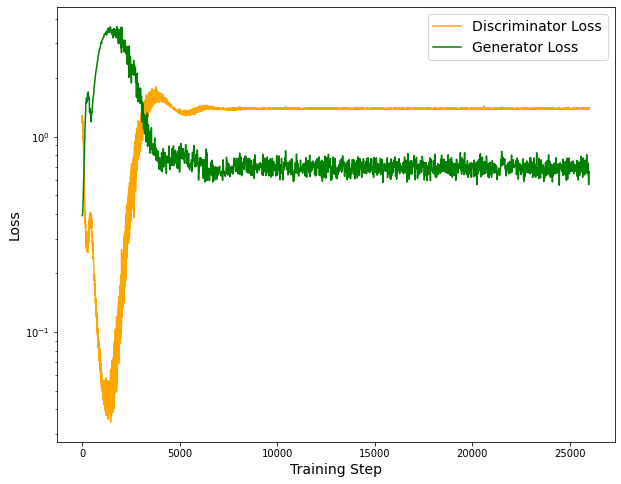

In [ ]:
# Plot loss function
gen_loss_steps = np.arange(5,len(disc_loss_hist)-1,13) # generator loss was only recorded sparsely
plt.figure(figsize=(10,8))
plt.plot(disc_loss_hist,color='orange',label='Discriminator Loss')
plt.plot(gen_loss_steps,gen_loss_hist,color='green',label='Generator Loss')
plt.yscale('log')
plt.xlabel('Training Step',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(fontsize=14)
plt.show()

- Loss shows convergence
- Generate 2520 samples from trained generator and compare to real data:

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) # point model to latest checkpoint

generated_samples1 = [] # produce sample from trained generator
for i in range(age_data.size):
  ii_noise = tf.random.normal([1,latent_dim])
  ii_generated_sample = generator(ii_noise,training=False)
  generated_samples1.append(ii_generated_sample.numpy()[0][0]) 

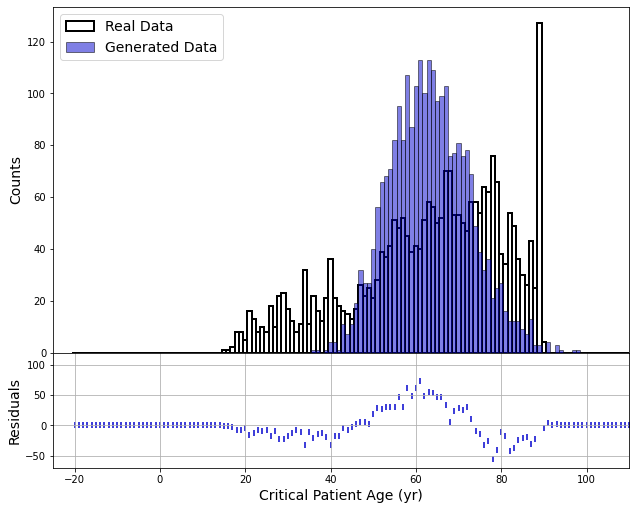

In [ ]:
fig1=plt.figure(figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
bins = np.arange(-20.5,200.5,1)
a = plt.hist(age_data,bins,facecolor='none',linewidth=2, edgecolor='k',alpha=1,label='Real Data')
bin_centers = (a[1][:-1] + a[1][1:]) / 2
b = plt.hist(generated_samples1,bins,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
plt.xlim(-25,110)
plt.ylabel('Counts',fontsize=14)
frame1.set_xticklabels([])
xlims = frame1.get_xlim()
plt.legend(fontsize=14)

frame2=fig1.add_axes((.1,.1,.8,.2))
res = b[0] - a[0]
plt.scatter(bin_centers,res,marker='|',color='mediumblue',alpha=1)
plt.ylim(-70,120)
plt.xlim(-25,110)
plt.xlabel('Critical Patient Age (yr)',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.grid(True)
plt.show()

- Calculate means and stds
- Original GAN uses Jensen-Shannon divergence to measure distribution similarity
  - JS divergence is essentially a measure of relative entropy where entropy (information theory) is the measurement of the amount of info required on average to describe that variable
  - If log base = 2, then JS is bound 0 <= JS <= 1 with 1 meaning perfect match and 0 being no match

In [ ]:
print('Sample mean of real data distribution: {}'.format(np.mean(age_data)))
print('Sample std of real data distribution: {}'.format(np.std(age_data)))

print('Sample mean of generated data distribution: {}'.format(np.mean(generated_samples1)))
print('Sample std of generated data distribution: {}'.format(np.std(generated_samples1)))

print('The Jensen-Shannon divergence (base 2) between target and generated distribs is: {}'.format(distance.jensenshannon(age_data,generated_samples1,base=2)))

Sample mean of real data distribution: 63.28452380952381
Sample std of real data distribution: 17.721668608381833
Sample mean of generated data distribution: 63.25572967529297
Sample std of generated data distribution: 9.270828247070312
The Jensen-Shannon divergence (base 2) between target and generated distribs is: 0.14221082737395413


- No need for further comparison as the distributions are off even by eye, although the range has improved
- The vanilla GAN implementation only manages to estimate the mean of the target distribution to ~< 1% error

## Posible causes & solutions:

- Problem seems to be rooted in "mode collapse"
- Mode collapse: The generator produces an especially plausible output (or sewt of outputs), then it starts producing it/them over and over again since it fools the discriminator easily. Tends to happen earlier in the training process
- The discriminator in turn learns to always reject that output (its best current strategy)
- The discriminator gets stuck in a local minimum and doesn't find the best strategy. The generator over-optimizes for this strategy and the model falls in a trap
- How to solve:
  - Use Wasserstein GAN (see implementation below)

Furthermore,
- Two very good recent papers touch on this subject from an experimental viewpoint, see https://nvlpubs.nist.gov/nistpubs/jres/126/jres.126.008.pdf and https://chunliangli.github.io/docs/dltp17gan.pdf
- Both touch on the same issue: Can GANs learn simple low dimensional (1D or 2D) distributions?
- This seems to be a sparsely tested subfield of GAN performance (whereas high-dimensional spaces like image generation GANs have been widely explored)

  Takeaways:
    - GAN error as a function of training sample size shows that it is log-linear (decreasing) in sample size N and its slope depends solely on the dimension of the target distribution (see [figure  4](https://nvlpubs.nist.gov/nistpubs/jres/126/jres.126.008.pdf) for example, error is halved when going from 1D to 2D). Furthermore the error is higher for models with multiple modes
    - Two main sources of GAN error: tail underfiting (generator fails to model tails of distribution) and bridge error (generator fails to model area between modes)
    - Vanilla GANs and Wasserstein-GANs, in general, fail to learn target 1D distributions and only manage to capture the mode. This is regardless of the latent distribution (tested latent normal and uniform distributions on targets normal, uniform, cauchy, pareto); [Tables 1 and 2](https://chunliangli.github.io/docs/dltp17gan.pdf).

  Possible solutions:
    - Change latent sampling from normal distribution to stratified random sampling where the training sample is assembled from random samples drawn from each target mode (for multi-mode distribs). Relies on higher-fidelity hypothesis
    - According to above, we expect to see a decrease in error by increasing sample size. If no more data is available at eICU or otherwise, we could explore a bootstrapping approach

  Demonstrated solutions for 1D distributions:
    - Use of a maximum mean discrepancy GAN (MMD GAN) as discriminator. In these discriminators, the NNs are replaced with a two-sample t-test based kernels (see [Tables 1 and 2](https://chunliangli.github.io/docs/dltp17gan.pdf)) 

In [ ]:
# some extra code to make a movie out of generated sample progress during training

if False:
  # make samples into individual images
  generated_samples_progress[0] = generated_samples0
  keys = list(generated_samples_progress.keys())
  keys.sort()

  bins2 = np.arange(-20.5,200.5,1)
  im_counter = 0
  for ii_key in keys:
    ii_gen_samples = generated_samples_progress[ii_key]

    plt.figure(figsize=(10,8))
    bins = np.arange(np.min(age_data)-0.5,np.max(age_data)+1.5,1)
    a = plt.hist(age_data,bins,facecolor='none',linewidth=2, edgecolor='k',alpha=1,label='Real Data')
    b = plt.hist(ii_gen_samples,bins2,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
    plt.xlim(-10,120)
    plt.ylim(0,900)
    plt.ylabel('Counts',fontsize=14)
    plt.xlabel('Critical Patient Age (yr)',fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Epoch {}'.format(ii_key),fontsize=14)
    plt.savefig('/content/drive/MyDrive/temp/{}.png'.format(im_counter), dpi=300, bbox_inches='tight') 
    plt.pause(1) 
    plt.close()

    im_counter+=1

## WGAN implementation:
- The classic GAN minimizes the Jensen-Shannon divergence, a measure of how much two distributions of different facets diverge from each other entropically
  - Has no notion of true distance between distributions except for distribution overlap
  - Two distributions with zero overlap and two distributions with very little overlap would have the same JS divergence
  - Hard to guide evolution of generated samples towards real data distribution
- The [WGAN](https://arxiv.org/abs/1701.07875):
  - Discriminator no longer classifies but instead predicts the probability of generated samples as being real or fake. WGAN replaces the discriminator model with a critic that scores the realness or fakeness of a given image
  - Wassertein loss is based on minimzing the distance between target and generator distributions (aka earth-mover distance "how much it costs to move one distribution to another given a mapping joint distribution"). Formally $W(p_\text{data},p_G) = \text{inf}_\gamma E_{(x,y)\sim \gamma (x,y)}||x-y||$ where $\gamma$ is a distribution over $x,y$ (describes which point $x$ goes into $y$)
  - Using Kantorovich-Rubinstein duality we can omit finding $\gamma$ (which is hard to find because $p_\text{data}$ is unknown and $\gamma$ may be very complicated in nature). This changes the Wasserstein distance to $W(p_\text{data},p_G) = \text{sup}_{||f||_L\leq 1} E_{p_\text{data}}[f(x)]-E_{p_{G(x)}}[f(x)]$ for some function $f$ which is 1-Lipschitz continuos $|f(x_1)-f(x_2)|\leq |x_1 - x_2|$, i.e its slope is bound and changes slowly
    - This limit on slope limits $f$ form being too steep and arbitrarily maximize $f(x)$ under $p_\text{data}$ and arbitrarily minimize it under $p_{G(x)}$
  - Wasserstein GANs are less vulnerable to getting stuck than minimax-based GANs, and avoid problems with vanishing gradients
  - To enforce Lipschitz continuity of $f$ in practice, we use clipping of NN weights in the discriminator

In [ ]:
class ClipConstraint():
	def __init__(self, clip_value):
		self.clip_value = clip_value

	def __call__(self, weights):
		return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)

In [ ]:
clip_const = ClipConstraint(0.01) # lipschiptz continous restriction 

# Redefine the discriminator (now with clipping and without the final sigmoid)
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(32,activation='relu',input_shape=(1,),
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_constraint=clip_const))
  model.add(layers.Dense(32,activation='relu',
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_constraint=clip_const))
  model.add(layers.Dense(32,activation='relu',
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_constraint=clip_const))
  model.add(layers.Dense(1,activation='linear')) # WGAN
  return model 

- WGAN training according to paper:
- Require: $\alpha$ the learning rate, $c$ the clipping parameter, $m$ the batch size, $n_\text{critic}$ the number of iterations of the critic per generator iteration
- Require: $w_0$ the initial critic paramters, $\theta_0$ the initial generator's parameters
- while $\theta$ has not converged do:
  - for $t=0,\ldots,n_\text{critic}$ do:
    - Sample $[x^{(i)}]^m_{i=1}\sim \mathbb{P}_r$ a batch from the real data
    - Sample $[z^{(i)}]^m_{i=1}\sim p(z)$ a batch of prior samples (latent)
    - $g_w \leftarrow \nabla_w \left[ \frac{1}{m}\sum_{i=1}^m f_w (x^{(i)}) - \frac{1}{m}\sum_{i=1}^m f_w(g_\theta(z^{(i)})) \right]$ 
    - $w \leftarrow w+\alpha\cdot \text{RMSProp}(w,g_w)$
    - $w \leftarrow \text{clip}(w,-c,c)$
  - end for
  - Sample $[z^{(i)}]^m_{i=1}\sim p(z)$ a batch of prior samples
  - $g_\theta \leftarrow -\nabla_\theta \frac{1}{m}\sum_{i=1}^m f_w(g_\theta(z^{(i)}))$
  - $\theta \leftarrow \theta - \alpha\cdot\text{RMSProp}(\theta,g_\theta)$
- end while

In [ ]:
def discriminator_loss(real_output, fake_output):
  discrim_loss = -(tf.reduce_mean(real_output) - tf.reduce_mean(fake_output))
  return discrim_loss

def generator_loss(fake_output):
  gen_loss = -tf.reduce_mean(fake_output)
  return gen_loss

- Instantiate models and RMSProp optimizers

In [ ]:
generator = generator_model()
discriminator = discriminator_model()

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

In [ ]:
generated_samples0 = []
for i in range(2000):
  ii_noise = tf.random.normal([1,latent_dim])
  ii_generated_sample = generator(ii_noise,training=False)
  generated_samples0.append(ii_generated_sample.numpy()[0][0]) 

- Train:

In [ ]:
disc_loss_hist = [] # to record loss
gen_loss_hist = []
generated_samples_progress = dict() # same generated samples every few epochs to track improvement

# Path to save training checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Training function
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print('epoch:',epoch+1)

    discrim_update_counter = 0
    for image_batch in dataset:
      noise = tf.random.normal([BATCH_SIZE, latent_dim])

      with tf.GradientTape() as disc_tape:
        generated_samples = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_samples, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        disc_loss_hist.append(disc_loss.numpy())

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      discrim_update_counter += 1
      if (discrim_update_counter+1) % 5 == 0 : # Update generator after 5 updates to discriminator
        with tf.GradientTape() as gen_tape:
          generated_samples = generator(noise, training=True)

          fake_output = discriminator(generated_samples, training=True)

          gen_loss = generator_loss(fake_output)
          gen_loss_hist.append(gen_loss.numpy())

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))     

    # Save the model every n epochs
    if (epoch + 1) % 99 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

      # Save sample generated distribs to track progress
      ii_generated_sample = []
      for i in range(age_data.size):
        jj_noise = tf.random.normal([1,latent_dim])
        jj_generated_sample = generator(jj_noise,training=False)
        ii_generated_sample.append(jj_generated_sample.numpy()[0][0]) 
      generated_samples_progress[epoch] = ii_generated_sample

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
EPOCHS = 1000
train(train_dataset, EPOCHS)

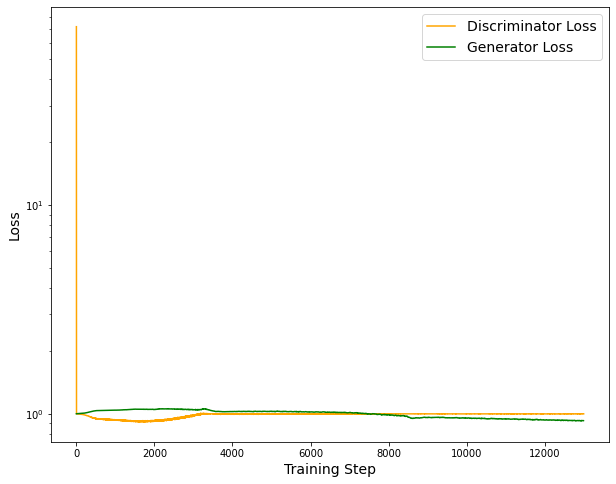

In [ ]:
# Plot loss function
disc_loss_hist = np.asarray(disc_loss_hist)
gen_loss_hist = np.asarray(gen_loss_hist)
gen_loss_steps = np.arange(0,len(disc_loss_hist),13000/2000) # generator loss was only recorded sparsely
plt.figure(figsize=(10,8))
plt.plot(disc_loss_hist+1,color='orange',label='Discriminator Loss')
plt.plot(gen_loss_steps,gen_loss_hist+1,color='green',label='Generator Loss')
plt.yscale('log')
plt.xlabel('Training Step',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) # point model to latest checkpoint

In [ ]:
generated_samples1 = []
for i in range(age_data.size):
  ii_noise = tf.random.normal([1,latent_dim])
  ii_generated_sample = generator(ii_noise,training=False)
  generated_samples1.append(ii_generated_sample.numpy()[0][0]) 

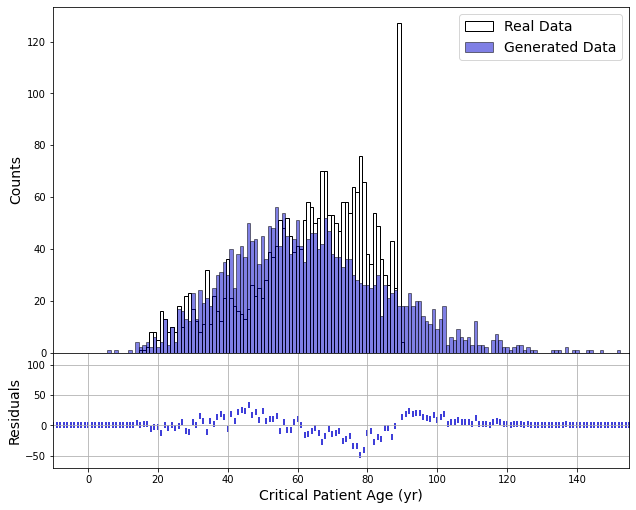

In [ ]:
fig1=plt.figure(figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
bins = np.arange(-20.5,200.5,1)
a = plt.hist(age_data,bins,facecolor='none',linewidth=1, edgecolor='k',alpha=1,label='Real Data')
bin_centers = (a[1][:-1] + a[1][1:]) / 2
b = plt.hist(generated_samples1,bins,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
plt.xlim(-10,155)
plt.ylabel('Counts',fontsize=14)
frame1.set_xticklabels([])
xlims = frame1.get_xlim()
plt.legend(fontsize=14)

frame2=fig1.add_axes((.1,.1,.8,.2))
res = b[0] - a[0]
plt.scatter(bin_centers,res,marker='|',color='mediumblue',alpha=1)
plt.ylim(-70,120)
plt.xlim(-10,155)
plt.xlabel('Critical Patient Age (yr)',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
print('Sample mean of real data distribution: {}'.format(np.mean(age_data)))
print('Sample std of real data distribution: {}'.format(np.std(age_data)))

print('Sample mean of generated data distribution: {}'.format(np.mean(generated_samples1)))
print('Sample std of generated data distribution: {}'.format(np.std(generated_samples1)))

print('The Jensen-Shannon divergence (base 2) between target and generated distribs is: {}'.format(distance.jensenshannon(age_data,generated_samples1,base=2)))

Sample mean of real data distribution: 63.28452380952381
Sample std of real data distribution: 17.721668608381833
Sample mean of generated data distribution: 62.86051559448242
Sample std of generated data distribution: 22.10661506652832
The Jensen-Shannon divergence (base 2) between target and generated distribs is: 0.19823544074804042


- Generated distribution has improved matching to real distribution but still having issues matching tails

In [ ]:
if False:
  # make samples into individual images
  generated_samples_progress[0] = generated_samples0
  keys = list(generated_samples_progress.keys())
  keys.sort()

  bins2 = np.arange(-20.5,200.5,1)
  im_counter = 0
  for ii_key in keys:
    ii_gen_samples = generated_samples_progress[ii_key]

    plt.figure(figsize=(10,8))
    bins = np.arange(np.min(age_data)-0.5,np.max(age_data)+1.5,1)
    a = plt.hist(age_data,bins,facecolor='none',linewidth=2, edgecolor='k',alpha=1,label='Real Data')
    b = plt.hist(ii_gen_samples,bins2,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
    plt.xlim(-10,120)
    plt.ylim(0,900)
    plt.ylabel('Counts',fontsize=14)
    plt.xlabel('Critical Patient Age (yr)',fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Epoch {}'.format(ii_key),fontsize=14)
    plt.savefig('/content/drive/MyDrive/temp2/{}.png'.format(im_counter), dpi=300, bbox_inches='tight') 
    plt.pause(5) 
    plt.close()

    im_counter+=1